# Compute Mode Connectivity Graph & Merge Tree

Notes

- The full pipeline includes:
    - train PINN models using 100 different random seeds
    - setup MC runs using `setup_MC_runs.ipynb` (this creates a file used by `train_eval_pinn_multi.py`)
    - submit MC runs using `train_eval_pinn_multi.py`
    - process MC runs and construct graphs using this notebook

<br>

- Results are strored in the following locations
    - individual checkpoints: 
    ```
    /global/cfs/cdirs/m636/geniesse/projects/characterizing-pinns-failure-modes/pbc_examples/checkpoints
    ```
    - curve checkpoints:
    ```
    /global/cfs/cdirs/m636/geniesse/projects/dnn-mode-connectivity/checkpoints_global
    ```

<br>

- Requires installing the following packages:

    - [nesoi](https://github.com/mrzv/nesoi)
    - [Ripser](https://ripser.scikit-tda.org/en/latest/)
    - [gudhi](https://pypi.org/project/gudhi/)
    - [pot](https://pythonot.github.io/)

In [1]:
# !pip install git+https://github.com/mrzv/nesoi.git 

In [2]:
# !pip install Ripser

In [3]:
# !pip install gudhi

In [ ]:
# !pip install pot

# Setup

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os 
import numpy as np
import pandas as pd
import networkx as nx
import scipy 

import matplotlib.pyplot as plt
import seaborn as sns

# Compute pairwise-connected graph

1. Process model pair information
2. Construct graph and add mode connected point between each edge

## Process model pair information


Here is an example checkpoint folder for a single curve. Note, the folder name includes the name of the two models connected by the curve.

In [6]:
!ls checkpoints_global/PINN_convection_beta_1.0_lr_1.0_seed_001_PINN_convection_beta_1.0_lr_1.0_seed_002

checkpoint-0_curve.npz	checkpoint-50_curve.npz
checkpoint-0.pt		checkpoint-50.pt


Here is a quick overview of the options that can be changed below:
- `beta = {1.0, 50.0}    # PINN wave speed coefficient`
- `eval_epoch = {0, 50}  # how long the curve was trained for (0: linear MC, 50: nonlinear MC)`
- `keep_nodes = [2…100]  # how many models to include in the graph` 


In [7]:
# configure options here
beta = 50.0      # PINN wave speed coefficient
eval_epoch = 0   # how long the curve was trained for (0: linear MC, 50: nonlinear MC)
keep_nodes = 5  # how many models to include in the graph (max 100)

In [8]:
# load pairs 
pairs_file = f"PINN_convection_beta_{beta}_lr_1.0_n_seeds_100_pairs.csv"
df_pairs = pd.read_csv(pairs_file)


# assign curve name 
df_pairs = df_pairs.assign(
    curve_name=[f"{_.init_start}_{_.init_end}".replace(".pt","") for __,_ in df_pairs.iterrows()]
)

# assign result folder 
df_pairs = df_pairs.assign(
    result_file=[f"checkpoints_global/{_}/checkpoint-{eval_epoch}_curve.npz" for _ in df_pairs.curve_name]
)

# assign result folder 
df_pairs = df_pairs.assign(
    checkpoint_file=[f"checkpoints_global/{_}/checkpoint-{eval_epoch}.pt" for _ in df_pairs.curve_name]
)

# assign source,target values
df_pairs = df_pairs.assign(
    source=[int(_.split("_seed_")[-1].split(".pt")[0]) for _ in df_pairs.init_start],
    target=[int(_.split("_seed_")[-1].split(".pt")[0]) for _ in df_pairs.init_end]
)

# assign edge tuples
df_pairs = df_pairs.assign(
    edge=[_ for _ in zip(df_pairs.source.values, df_pairs.target.values)]
)

# limit to the first n nodes
df_pairs = df_pairs[df_pairs.source.le(keep_nodes) & df_pairs.target.le(keep_nodes)]
df_pairs = df_pairs.reset_index(drop=True)


# show df
df_pairs

,init_start,init_end,curve_name,result_file,checkpoint_file,source,target,edge
0,PINN_convection_beta_50.0_lr_1.0_seed_001.pt,PINN_convection_beta_50.0_lr_1.0_seed_002.pt,PINN_convection_beta_50.0_lr_1.0_seed_001_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,1,2,"(1, 2)"
1,PINN_convection_beta_50.0_lr_1.0_seed_001.pt,PINN_convection_beta_50.0_lr_1.0_seed_003.pt,PINN_convection_beta_50.0_lr_1.0_seed_001_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,1,3,"(1, 3)"
2,PINN_convection_beta_50.0_lr_1.0_seed_001.pt,PINN_convection_beta_50.0_lr_1.0_seed_004.pt,PINN_convection_beta_50.0_lr_1.0_seed_001_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,1,4,"(1, 4)"
3,PINN_convection_beta_50.0_lr_1.0_seed_001.pt,PINN_convection_beta_50.0_lr_1.0_seed_005.pt,PINN_convection_beta_50.0_lr_1.0_seed_001_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,1,5,"(1, 5)"
4,PINN_convection_beta_50.0_lr_1.0_seed_002.pt,PINN_convection_beta_50.0_lr_1.0_seed_003.pt,PINN_convection_beta_50.0_lr_1.0_seed_002_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,2,3,"(2, 3)"
5,PINN_convection_beta_50.0_lr_1.0_seed_002.pt,PINN_convection_beta_50.0_lr_1.0_seed_004.pt,PINN_convection_beta_50.0_lr_1.0_seed_002_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,2,4,"(2, 4)"
6,PINN_convection_beta_50.0_lr_1.0_seed_002.pt,PINN_convection_beta_50.0_lr_1.0_seed_005.pt,PINN_convection_beta_50.0_lr_1.0_seed_002_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,2,5,"(2, 5)"
7,PINN_convection_beta_50.0_lr_1.0_seed_003.pt,PINN_convection_beta_50.0_lr_1.0_seed_004.pt,PINN_convection_beta_50.0_lr_1.0_seed_003_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,3,4,"(3, 4)"
8,PINN_convection_beta_50.0_lr_1.0_seed_003.pt,PINN_convection_beta_50.0_lr_1.0_seed_005.pt,PINN_convection_beta_50.0_lr_1.0_seed_003_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,3,5,"(3, 5)"
9,PINN_convection_beta_50.0_lr_1.0_seed_004.pt,PINN_convection_beta_50.0_lr_1.0_seed_005.pt,PINN_convection_beta_50.0_lr_1.0_seed_004_PINN...,checkpoints_global/PINN_convection_beta_50.0_l...,checkpoints_global/PINN_convection_beta_50.0_l...,4,5,"(4, 5)"


## Construct graph and add mode connected point between each edge


In [9]:
# initialize graph based on edges
edges = df_pairs.edge.to_list()
G1 = nx.Graph(edges)

# construct new graph (with extra nodes)
G2 = nx.Graph()

# loop over edges 
for index, df_pair in df_pairs.iterrows():

    # extract curve metrics for the edge pair
    with np.load(df_pair.result_file) as result:
        curve_losses = result['tr_error_u_rel']
        # curve_losses = result['tr_loss']
        # mc = float(result['mc_metric'])
    
    # assign node id to the new node
    curve_node = len(G1) + index + 1
    source_node = df_pair.source
    target_node = df_pair.target
    
    # update G1
    G1.nodes[source_node]['loss'] = curve_losses[0]
    G1.nodes[target_node]['loss'] = curve_losses[-1]

    # assign node data
    G2.add_node(source_node, loss=curve_losses[0])
    G2.add_node(curve_node, loss=curve_losses[np.argmax(np.abs(curve_losses))])
    G2.add_node(target_node, loss=curve_losses[-1])

    # add new path going through the curve node
    nx.add_path(G2, [source_node, curve_node, target_node])
    print(f"[+] ({source_node}, {curve_node:2d}, {target_node}) => ({G2.nodes[source_node]['loss']:.6f}, {G2.nodes[curve_node]['loss']:.6f}, {G2.nodes[target_node]['loss']:.6f})")

# show some things
print(f"{G1.number_of_nodes()=}")
print(f"{G1.number_of_edges()=}")
print(f"{G2.number_of_nodes()=}")
print(f"{G2.number_of_edges()=}")

[+] (1,  6, 2) => (0.644167, 10.286507, 0.845650)
[+] (1,  7, 3) => (0.644167, 11.081335, 0.651101)
[+] (1,  8, 4) => (0.644167, 11.076351, 0.635380)
[+] (1,  9, 5) => (0.644167, 0.982177, 0.872609)
[+] (2, 10, 3) => (0.845650, 5.373067, 0.651101)
[+] (2, 11, 4) => (0.845650, 4.404345, 0.635380)
[+] (2, 12, 5) => (0.845650, 7.945082, 0.872609)
[+] (3, 13, 4) => (0.651101, 6.802584, 0.635380)
[+] (3, 14, 5) => (0.651101, 2.523957, 0.872609)
[+] (4, 15, 5) => (0.635380, 2.296252, 0.872609)
G1.number_of_nodes()=5
G1.number_of_edges()=10
G2.number_of_nodes()=15
G2.number_of_edges()=20


## Convert graphs to format for `nesoi`

In [10]:
# save graph edges as np array
edges = [_[:2] for _ in nx.to_edgelist(G2, nodelist=None)]
edges = np.array(edges) 
edges = edges - 1 # re-index for nesoi

# save loss values
loss = np.array([G2.nodes[_]['loss'] for _ in sorted(G2.nodes)])

# save things (optional)
# save_as = f"{pairs_file.replace('.csv','')}_eval_epoch_{eval_epoch}_keep_nodes_{keep_nodes}.npz"
# np.savez(save_as, edges=edges, loss=loss)
# print(save_as)

# Compute Merge Tree (using `nesoi`)

In [11]:
import sys
import numpy as np
import nesoi

In [12]:
# construct a new graph for nesoi (not sure this is necessary... can we just use G2 from above?)
G = nx.Graph()
G.add_nodes_from(list(range(len(loss))))
G.add_edges_from(edges)

In [13]:
tree = nesoi.TMT_float(len(loss), False)

for i,v in enumerate(loss):
    tree.add(i,v)

for e in edges:
    # tree.merge(e[0]-1, e[1]-1)
    tree.merge(e[0], e[1])

tree.repair()

# Output persistence diagram
for (u,s,v) in tree.traverse_persistence():
    print(u,s,v, loss[u], loss[s])


0 14 3 0.6441672934466784 2.2962523752798636
1 10 3 0.8456499909340117 4.404344622213394
2 13 3 0.65110116288321 2.5239565641120816
3 3 3 0.6353797797942071 0.6353797797942071
4 8 0 0.8726088672609353 0.9821771279212431


## Compute full tree (includes degree-2 nodes)

In [14]:
# Generate conventional tree
from collections import defaultdict
paths = defaultdict(set)

for u in range(len(loss)):
    (s,v) = tree[u]
    if u == v: continue
    paths[v].add(s)
    if u != s:
        paths[u].add(s)

for u in paths.keys():
    paths[u] = list(paths[u])
    paths[u].sort(key = lambda x: loss[x])

path_edges = []
for u in paths.keys():
    p = paths[u]
    print(u,p[0])
    path_edges.append((u, p[0]))

    for i in range(len(paths[u]) - 1):
        print(p[i], p[i+1])
        path_edges.append((p[i], p[i+1]))

        

T_full = nx.Graph()
T_full.add_nodes_from(list(range(len(loss))))
T_full.add_edges_from(path_edges)

T_full.remove_nodes_from([n for n in T_full if not len(list(T_full.neighbors(n)))])

height_full = {n: loss[n] for n in T_full}

3 14
14 13
13 10
10 9
9 12
12 11
11 5
5 7
7 6
0 8
8 14
1 10
2 13
4 8


## Compute condensed tree (no degree-2 nodes)

In [15]:
# Generate conventional tree
from collections import defaultdict
paths = defaultdict(list)

for (u,s,v) in tree.traverse_persistence():
    if u == v: continue
    paths[v].append(s)
    paths[u].append(s)

for u in paths.keys():
    paths[u].sort(key = lambda x: loss[x])

path_edges = []
for u in paths.keys():
    p = paths[u]
    print(u,p[0])
    path_edges.append((u, p[0]))

    for i in range(len(paths[u]) - 1):
        print(p[i], p[i+1])
        path_edges.append((p[i], p[i+1]))

        
import networkx as nx

T = nx.Graph()
T.add_nodes_from(list(range(len(loss))))
T.add_edges_from(path_edges)
T.remove_nodes_from([n for n in T if not len(list(T.neighbors(n)))])


### DEBUGGING 
# connect max in the tree with max in full tree
# T.add_edges_from([(13,11)])
nodes = list(T.nodes)
nodes.sort(key=lambda x: loss[x])
max_node = nodes[-1]

full_nodes = list(T_full.nodes)
full_nodes.sort(key=lambda x: loss[x])
max_node_full = full_nodes[-1]
print()
print(max_node, max_node_full)
T.add_edges_from([(max_node,max_node_full)])

height = {n: loss[n] for n in T}
# height = {n: loss[n] for n in T if len(T[n])} 
# height = {n: loss[n] for n in T if len(list(T.neighbors(n)))}

3 14
14 13
13 10
0 8
8 14
1 10
2 13
4 8

10 6


## Save intermediates (optional)

In [16]:
# import pickle

# with open("merge_tree.pkl", "wb") as f:
#     pickle.dump(T, f)
    
# with open("merge_tree_full.pkl", "wb") as f:
#     pickle.dump(T_full, f)
    
# with open("height.pkl", "wb") as f:
#     pickle.dump(height, f) 
    
# with open("height_full.pkl", "wb") as f:
#     pickle.dump(height_full, f)

## Draw the trees

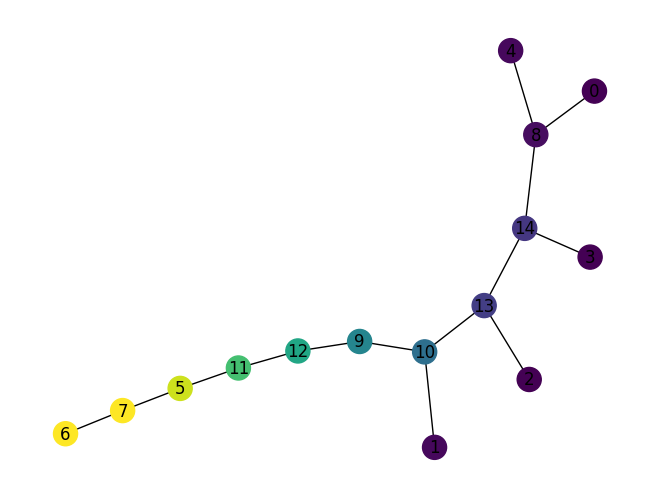

In [17]:
np.random.seed(1)
nx.draw_kamada_kawai(T_full, node_color = list(height_full.values()), with_labels=True)

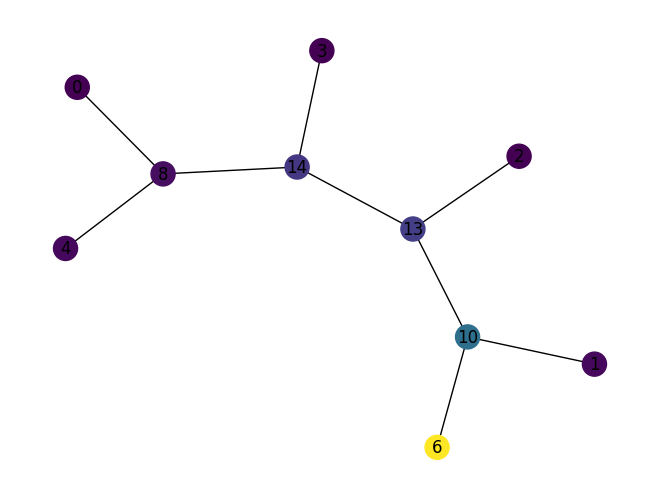

In [18]:
np.random.seed(1)
nx.draw_kamada_kawai(T, node_color = list(height.values()), with_labels=True)

## Draw the trees (using DMT_tools)

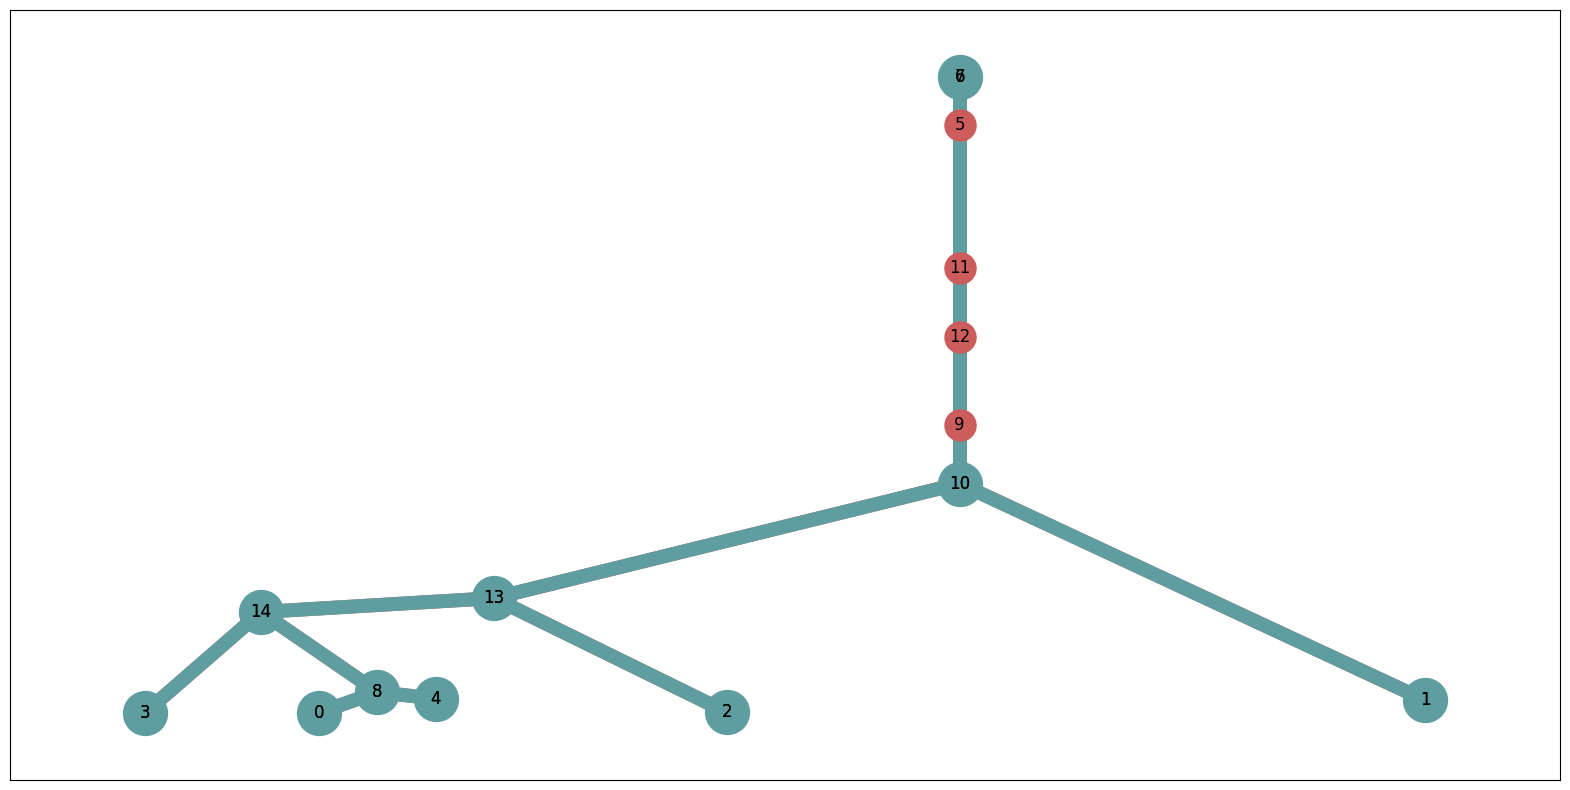

In [19]:
# borrowed from https://github.com/trneedham/Decorated-Merge-Trees
from DMT_tools import mergeTree_pos
def draw_merge_tree(G,height,axes=False, ax=None, **kwargs):
    # Input: merge tree as G, height
    # Output: draws the merge tree with correct node heights
    pos = mergeTree_pos(G,height)
    if ax is None:
        fig, ax = plt.subplots()
    nx.draw_networkx(G, pos=pos, ax=ax, with_labels=True, **kwargs)
    if axes:
        ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False)
    return


fig, ax = plt.subplots(figsize=(20,10))
draw_merge_tree(T_full, height_full, ax=ax, node_size=500, width=10, node_color="indianred", edge_color="indianred")
draw_merge_tree(T, height, ax=ax, node_size=1000, width=10, node_color="cadetblue", edge_color="cadetblue")

# Save Merge Tree files (for 1D profiles)

The minimum Format:

    Merge Tree Edges
    "SegmentationId","upNodeId","downNodeId"

    Merge Tree Nodes
    "NodeId","Scalar","CriticalType"

    Merge Tree Segmentations
    "Loss","SegmentationId"

## Helper functions

In [20]:
def get_critical_type(T, n):
    # 0=minima, 1=saddle, 3=root
    deg = len(list(T.neighbors(n))) # use the number of neighbors as the critical point?
    if max(loss) == loss[n]:
        return 3
    if deg == 1:
        return 0
    if deg == 3:
        return 1
    return -1

sys.setrecursionlimit(5050)
def find_nearest_critical_point(G, n, verbose=0):
    if verbose > 0: 
        print(f"{n=}")
    
    # compute neighbors
    nbrs = list(G.neighbors(n))

    # return if critical point 
    if len(nbrs) != 2:
        if verbose > 0: 
            print(f"Found critical point!!! ({n=})")
        return n
    
    # TODO: sort neighbors by loss
    if verbose > 1: 
        print(n, nbrs)
    nbrs.sort(key = lambda x: loss[x])
    if verbose > 1: 
        print(n, nbrs)
    
    # traverse neighbors until critical point is found
    for nbr in nbrs:
        if verbose > 0: 
            print(f"\t{nbr=}")
        return find_nearest_critical_point(G, nbr)
        

## Initialize data frames for saving

In [21]:
df_mt_edges = pd.DataFrame(columns=["SegmentationId","upNodeId","downNodeId"])
df_mt_nodes = pd.DataFrame(columns=["NodeId","Scalar","CriticalType"])
df_mt_seg = pd.DataFrame(columns=["Loss","SegmentationId"])

## Sort edges in the merge tree by loss

In [22]:
T_edges_sorted = [list(_) for _ in T.edges()]
for T_edge in T_edges_sorted:
    print(T_edge)
    T_edge.sort(key = lambda x: loss[x])
    print(T_edge)
    print()

[0, 8]
[0, 8]

[1, 10]
[1, 10]

[2, 13]
[2, 13]

[3, 14]
[3, 14]

[4, 8]
[4, 8]

[8, 14]
[8, 14]

[10, 13]
[13, 10]

[10, 6]
[10, 6]

[13, 14]
[14, 13]



## Store merge tree edge information

In [23]:
df_mt_edges = pd.DataFrame(columns=["SegmentationId","upNodeId","downNodeId"])
df_mt_edges = df_mt_edges.assign(SegmentationId = [i for i,_ in enumerate(T_edges_sorted)])    
df_mt_edges = df_mt_edges.assign(upNodeId = [_[1] for i,_ in enumerate(T_edges_sorted)])
df_mt_edges = df_mt_edges.assign(downNodeId = [_[0] for i,_ in enumerate(T_edges_sorted)])
df_mt_edges

,SegmentationId,upNodeId,downNodeId
0,0,8,0
1,1,10,1
2,2,13,2
3,3,14,3
4,4,8,4
5,5,14,8
6,6,10,13
7,7,6,10
8,8,13,14


## Store merge tree node information

In [24]:
df_mt_nodes = pd.DataFrame(columns=["NodeId","Scalar","CriticalType"])
df_mt_nodes = df_mt_nodes.assign(NodeId = list(set(np.ravel(T.edges()))))    
df_mt_nodes = df_mt_nodes.assign(Scalar = [loss[_] for _ in df_mt_nodes.NodeId])
df_mt_nodes = df_mt_nodes.assign(CriticalType = [
    get_critical_type(T, _)
    for _ in df_mt_nodes.NodeId
])
df_mt_nodes

,NodeId,Scalar,CriticalType
0,0,0.644167,0
1,1,0.845650,0
2,2,0.651101,0
3,3,0.635380,0
4,4,0.872609,0
5,6,11.081335,3
6,8,0.982177,1
7,10,4.404345,1
8,13,2.523957,1
9,14,2.296252,1


## Store merge tree segmentation information

In [25]:
df_mt_seg = pd.DataFrame(columns=["Loss","SegmentationId"])
df_mt_seg = df_mt_seg.assign(Loss = loss)

### find the nearest critical point in T_full
### ... map the critical point to segmentationId based on down node
for node_id in range(len(loss)):
    
    print(node_id)
    
    # find the nearest down node
    down_node_id = find_nearest_critical_point(T_full, node_id)
    
    # find the segmentation id for the edge
    if down_node_id not in df_mt_edges.downNodeId.values:
        # this should only happen for root node
        print(f"Found possible root node ({node_id=}, {down_node_id=}) ... using SegmentationId based on upNodeId ({seg_id=})")
        seg_id = df_mt_edges[df_mt_edges.upNodeId.eq(down_node_id)].SegmentationId.values[0]
    else:
        seg_id = df_mt_edges[df_mt_edges.downNodeId.eq(down_node_id)].SegmentationId.values[0]

    # display results
    # print(f"{node_id=}, {down_node_id=}, {seg_id=}")
    
    # update segmentation 
    df_mt_seg.at[node_id, 'SegmentationId'] = seg_id
    
# show df_mt_seg
df_mt_seg

0
1
2
3
4
5
6
Found possible root node (node_id=6, down_node_id=6) ... using SegmentationId based on upNodeId (seg_id=7)
7
8
9
10
11
12
13
14


,Loss,SegmentationId
0,0.644167,0
1,0.845650,1
2,0.651101,2
3,0.635380,3
4,0.872609,4
5,10.286507,7
6,11.081335,7
7,11.076351,7
8,0.982177,5
9,5.373067,7


## Re-compute the merge tree edge information (after using it for the segmentation)

a bit hacky... i know

In [26]:
### Re Number edges AFTER using it for segmentation
df_mt_edges = pd.DataFrame(columns=["SegmentationId","upNodeId","downNodeId"])
df_mt_edges = df_mt_edges.assign(SegmentationId = [i for i,_ in enumerate(T_edges_sorted)])    
df_mt_edges = df_mt_edges.assign(upNodeId = [_[1] for i,_ in enumerate(T_edges_sorted)])
df_mt_edges = df_mt_edges.assign(downNodeId = [_[0] for i,_ in enumerate(T_edges_sorted)])

T_nodes = list(np.sort(np.unique(np.ravel(T_edges_sorted))))
print(T_nodes)

df_mt_edges = df_mt_edges.assign(upNodeIdDataId = df_mt_edges.upNodeId)
df_mt_edges = df_mt_edges.assign(downNodeIdDataId = df_mt_edges.downNodeId)

df_mt_edges = df_mt_edges.assign(upNodeId = df_mt_edges.upNodeIdDataId.apply(T_nodes.index))
df_mt_edges = df_mt_edges.assign(downNodeId = df_mt_edges.downNodeIdDataId.apply(T_nodes.index))


df_mt_edges

[0, 1, 2, 3, 4, 6, 8, 10, 13, 14]


,SegmentationId,upNodeId,downNodeId,upNodeIdDataId,downNodeIdDataId
0,0,6,0,8,0
1,1,7,1,10,1
2,2,8,2,13,2
3,3,9,3,14,3
4,4,6,4,8,4
5,5,9,6,14,8
6,6,7,8,10,13
7,7,5,7,6,10
8,8,8,9,13,14


## Save the merge tree files (consumed by the topological profile code)

In [27]:
file_name = f"PINN_convection_beta_{beta}_lr_1.0_n_seeds_100_pairs_eval_epoch_{eval_epoch}_keep_nodes_{keep_nodes}.npz"

mt_nodes_file = file_name.replace(".npz", "_MergeTree.csv")
mt_edges_file = file_name.replace(".npz", "_MergeTree_edge.csv")
mt_seg_file = file_name.replace(".npz", "_MergeTree_segmentation.csv")

df_mt_nodes.to_csv(mt_nodes_file, index=None)
df_mt_edges.to_csv(mt_edges_file, index=None)
df_mt_seg.to_csv(mt_seg_file, index=None)

print(f"[+] {mt_nodes_file}")
print(f"[+] {mt_edges_file}")
print(f"[+] {mt_seg_file}")

[+] PINN_convection_beta_50.0_lr_1.0_n_seeds_100_pairs_eval_epoch_0_keep_nodes_5_MergeTree.csv
[+] PINN_convection_beta_50.0_lr_1.0_n_seeds_100_pairs_eval_epoch_0_keep_nodes_5_MergeTree_edge.csv
[+] PINN_convection_beta_50.0_lr_1.0_n_seeds_100_pairs_eval_epoch_0_keep_nodes_5_MergeTree_segmentation.csv
